<a href="https://colab.research.google.com/github/Kwon-sein/2022-2-semester/blob/main/EEE7331_GAN_Inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### EEE7331: Special Topics on Deep Learning
## Assignment: GAN Inversion using StyleGAN
GAN inversion is a method that inverts some image $x$ to the latent space of an unconditional GAN.  
Denoting the target image $x$, latent $z$, generator $G$, and some loss function $\mathcal{L}$, this can be formalized as below:  
&nbsp;
$$z^* = \textrm{arg min}_{z}\mathcal{L}(x, G(z))$$
&nbsp;

Specifically, in this assignment we will invert face images into StyleGAN's latent space.  
There are many ways to do so, but here we only focus on *optimization* based inversion.  
Optimization based inversion optimizes the latent vector directly through gradient descent iteratively, as below:  
<!-- &nbsp;
$$z_{t+1} \leftarrow z_t - \eta\nabla_{z_t}\mathcal{L}$$
&nbsp; -->

<img src="GAN_inversion_concept.png" width="500">  

The quality of the inversion $G(z)$ can depend on many different components.  
Some obvious components are:  
- Choice of loss function $\mathcal{L}$
- Initialization of point $z_0$
- Optimization parameters, e.g., optimizer, learning rate ($\eta$), etc.

&nbsp;
Another important component is which **latent space** to optimize.  
There are three well-known latent space of StyleGAN, which are $\mathcal{Z}$, $\mathcal{W}$, and $\mathcal{W}+$.  
$\mathcal{Z}$ space is simply the input latent space, i.e., $z\in\mathcal{Z}$.  
$\mathcal{W}$ space is the intermediate latent space after the nonlinear projection $f$, i.e., $w=f(z)$.  
Both $\mathcal{Z}$ and $\mathcal{W}$ are 512 dimension by default.  
The $\mathcal{W}+$ space is the latent space that consists of all 14 intermediate latent vectors $w$  
concatenated together, and therefore is 14x512 dimensional.
<img src="StyleGAN_architecture.png" width="500">

**In this assignment, we will:**  
1. Use different loss functions $\mathcal{L}$ for optimization.
2. Optimize on different latent spaces, $\mathcal{Z}$, $\mathcal{W}$ and $\mathcal{W}^+$.
3. Evalute the inversion with different metrics, i.e., L2, LPIPS, and Cosine distance.

**Your mission is to:**  
1. Perform inversion for all 20 target images
2. Repeat experiments on different latent spaces, $\mathcal{Z}$, $\mathcal{W}$ and $\mathcal{W}^+$.
3. Report the average LPIPS, and Cosine distance.
4. Propose some additional ideas to improve the inversion performance, e.g.:  
- Choice of loss function $\mathcal{L}$
- Initialization of point $z_0$
- Optimization parameters, e.g., optimizer, learning rate ($\eta$), etc.

Basic helper functions and a simple tutorial will be given below for brief understanding.  
All the rest is up to you. Have fun!  

----

p.s. Some resources that may help you:  
- Pytorch StyleGAN2 implementation used by this notebook: [stylegan2-pytorch](https://github.com/rosinality/stylegan2-pytorch)
- Paper that defined the W+ space: [Image2StyleGAN](https://openaccess.thecvf.com/content_ICCV_2019/papers/Abdal_Image2StyleGAN_How_to_Embed_Images_Into_the_StyleGAN_Latent_Space_ICCV_2019_paper.pdf)
- Survey on GAN Inversion: [GAN Inversion: A Survey](https://arxiv.org/abs/2101.05278)

If you have any questions, please contact the TA: Hojin Park, 2014142100@yonsei.ac.kr

# Tutorial on GAN Inversion

### 0. Getting Ready
- git clone stylegan2-pytorch repository
- Mounting Google drive (for Colab users)
- Importing libraries
- Helper functions
- Preparing StyleGAN
- Preparing LPIPS and Cosine Distance
- Observe some random samples

### 1. Naive GAN Inversion using MSE Loss
- Optimization on different latent spaces, $\mathcal{Z}$, $\mathcal{W}$ and $\mathcal{W}+$.

----

# 0. Getting Ready
NOTE: If you are using Colab, please change the runtime to GPU and mount Google Drive  
To change the runtime, go to "Runtime -> Chage Runtime Types" on the top panel.

In [1]:
!nvidia-smi  # check whether you have GPU access

Sun Oct 30 08:51:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# If you are using Colab, mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# git clone stylegan2-pytorch
!git clone https://github.com/rosinality/stylegan2-pytorch
!pip install ninja  # for using C++ operations
!pip install facenet_pytorch  # for using FaceNet

Cloning into 'stylegan2-pytorch'...
remote: Enumerating objects: 395, done.
remote: Total 395 (delta 0), reused 0 (delta 0), pack-reused 395
Receiving objects: 100% (395/395), 122.51 MiB | 16.98 MiB/s, done.
Resolving deltas: 100% (203/203), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 25.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 27.3 MB/s 


In [4]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1

os.chdir('stylegan2-pytorch')
from model import Generator
os.chdir('../')

device = torch.device("cuda:0")

## Helper Functions

- **process(img)** : convert StyleGAN generated image for visualization by matplotlib
- **process_image_sequence(image_sequence, target)**: process image sequence for visualization by matplotlib
- **stylegan_postprocess(img)** : simple crop & normalization for StyleGAN
- **VGGPerceptualLoss(img, target)** : for computing LPIPS between generated & target image
- **CosineDistanceLoss(img, target)** : for computing cosine distance  between generated & target image

For the evaluation of generated image, we will use L2 distance, LPIPS, and cosine distance.  
For L2 distance, you can simply use nn.MSELoss().  
For the LPIPS and cosine distance, please use the above helper functions.  
You can define more custom functions for better performance!

In [5]:
def process(img):
    """
    process img for visualization by matplotlib
    img: StyleGAN generated image tensor of shape [1,3,H,W]
    return: image tensor of shape [H,W,3]
    """
    img = img.detach().cpu()
    img = torchvision.utils.make_grid(img, nrow=1, normalize=True)
    img = img.permute(1,2,0)  # reshape to [H,W,3]
    
    return img


def process_image_sequence(image_sequence, target):
    """
    process image sequence for visualization by matplotlib
    image_sequence: list of N generated images, each of shape [1,3,H,W]
    target: target image of shape [1,3,H,W]
    return: image tensor of shape [H, (N+1)*W, 3]
    """
    N = len(image_sequence) + 1
    imseq = image_sequence + [target]
    imseq = torch.vstack(imseq)
    imseq = torchvision.utils.make_grid(imseq, nrow=N, normalize=True)
    imseq = imseq.detach().cpu()  # detach gradient & save to CPU
    imseq = imseq.permute(1,2,0)  # reshape to [H, (N+1)*W, 3]
    
    return imseq

In [6]:
def stylegan_postprocess(img, crop_size=192, v_offset=10, normalize=False):
    '''
    postprocessing for StyleGAN-FFHQ-256
    crops and normalizes the generated image
    '''
    _, _, cy, cx = img.shape
    assert len(img.shape) == 4 and img.shape[1] == 3, 'img must be a Bx3xHxW numpy array'
    assert cy >= crop_size and cx >= crop_size, 'crop size must be smaller than the given image'
    cy = cy // 2 + v_offset  # vertical offset
    cx = cx // 2
    w = crop_size // 2
    img = img[:, :, cy-w:cy+w, cx-w:cx+w]
    
    if normalize:
        img = 2 * (img - img.min()) / (img.max() - img.min()) - 1  # normalize -1~1
        
    return img

In [7]:
class VGGPerceptualLoss(nn.Module):
    """
    perceptual loss using ImageNet trained VGG-16
    can be used to compute LPIPS
    """
    DEFAULT_FEATURE_LAYERS = [0, 1, 2, 3]
    IMAGENET_RESIZE = (224, 224)

    def __init__(self, resize=True, feature_layers=None, style_layers=None):
        super().__init__()
        self.resize = resize
        self.feature_layers = feature_layers or self.DEFAULT_FEATURE_LAYERS
        self.style_layers = style_layers or []
        features = torchvision.models.vgg16(pretrained=True).features
        self.blocks = nn.ModuleList([
            features[:4].eval(),
            features[4:9].eval(),
            features[9:16].eval(),
            features[16:23].eval(),
        ])
        for param in self.parameters():
            param.requires_grad = False

    def _transform(self, tensor):
        if self.resize:
            tensor = nn.functional.interpolate(tensor, mode='bilinear', size=self.IMAGENET_RESIZE, align_corners=False)
        return tensor

    def _calculate_gram(self, tensor):
        act = tensor.reshape(tensor.shape[0], tensor.shape[1], -1)
        return act @ act.permute(0, 2, 1)

    def forward(self, output, target):
        output, target = self._transform(output), self._transform(target)
        loss = 0.
        for i, block in enumerate(self.blocks):
            output, target = block(output), block(target)
            if i in self.feature_layers:
                loss += nn.functional.l1_loss(output, target)
            if i in self.style_layers:
                gram_output, gram_target = self._calculate_gram(output), self._calculate_gram(target)
                loss += nn.functional.l1_loss(gram_output, gram_target)
        return loss

In [8]:
def cosine_similarity(x, y):
    """
    Batch-wise cosine similarity between x, y of shape [B, d]
    B is the batch size, d is the feature dimension
    returns cosine similarity matrix of shape [B, B]
    """
    x_norm = F.normalize(x, dim=1)
    y_norm = F.normalize(y, dim=1)
    cosine = torch.mm(x_norm, y_norm.T).clamp(-1,1)

    return cosine


class CosineDistanceLoss(nn.Module):
    """
    Cosine distance loss using FaceNet trained from VGGFace2
    """
    FACENET_RESIZE = (160, 160)
    def __init__(self, resize=True):
        super(CosineDistanceLoss, self).__init__()
        self.resize = resize
        self.encoder = InceptionResnetV1(pretrained='vggface2')
        self.encoder.eval()
        for param in self.parameters():
            param.requires_grad = False
    
    def _transform(self, tensor):
        if self.resize:
            tensor = nn.functional.interpolate(tensor, mode='bilinear', size=self.FACENET_RESIZE, align_corners=False)
        return tensor
    
    def forward(self, output, target):
        output, target = self._transform(output), self._transform(target)
        output, target = self.encoder(output), self.encoder(target)
        loss = 1 - cosine_similarity(output, target)
        
        return loss

# Prepare StyleGAN

In [10]:
# base directory for this file: USE YOUR DIRECTORY
base_directory = '/content/drive/MyDrive/STDL_2022_Fall_GAN_Inversion/STDL_2022_Fall_GAN_Inversion'

# Generator configuration: do not change
image_size = 256
crop_size = 192
latent_dim = 512
num_mlp = 8

# directory for pretrained weight (enter your directory)
weight = f'{base_directory}/stylegan2-ffhq-config-256.pt'
pth = torch.load(weight)['g_ema']

# basic image transform
transform = transforms.Compose(
    [
        transforms.Resize(crop_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

# load pretrained StyleGAN
G = Generator(image_size, latent_dim, num_mlp).to(device)
_ = G.load_state_dict(pth, strict=False)  # load state dict

# Prepare LPIPS and Cosine Distance
Because LPIPS and Cosine Distance is measured by **VGGNet** and **FaceNet**, we need to load these models too.

In [18]:
l_lpips = VGGPerceptualLoss().to(device)  # LPIPS loss
l_cosine = CosineDistanceLoss().to(device)  # Cosine Distance loss

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0.00/107M [00:00<?, ?B/s]

# Observe Random Samples

/content/stylegan2-pytorch/op/conv2d_gradfix.py:89: UserWarning: conv2d_gradfix not supported on PyTorch 1.12.1+cu113. Falling back to torch.nn.functional.conv2d().
  f"conv2d_gradfix not supported on PyTorch {torch.__version__}. Falling back to torch.nn.functional.conv2d()."


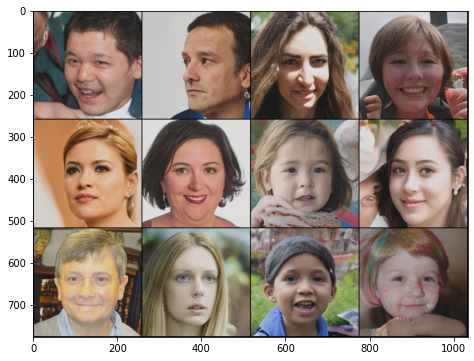

In [11]:
grid_x = 4
grid_y = 3

# randomly sample latents & generate
z = torch.randn(grid_x * grid_y, latent_dim).to(device)
with torch.no_grad():
    img = G([z])[0]
    
# visualize
img = torchvision.utils.make_grid(img, grid_x, normalize=True)
img = img.permute(1,2,0).cpu()
plt.figure(figsize=(grid_x*2, grid_y*2))
plt.imshow(img)

# 1. Naive GAN Inversion using MSE Loss (L2 Distance)

Here we will only use MSE loss for the loss function, i.e., $\mathcal{L}(x, G(z)) = \|x-G(z)\|_2$.  
With Pytorch, we can simply use the **nn.MSELoss()** for this.  
### This is just a baseline, so please add any ideas to improve this!   

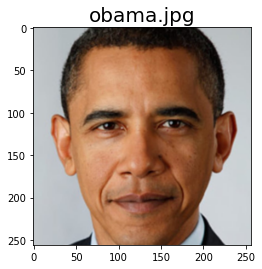

In [12]:
# fetch some target
target_name = 'obama'
imdir = f'{base_directory}/targets/{target_name}.jpg'  
target = Image.open(imdir).resize((image_size,image_size))

# visualize
plt.imshow(target)
plt.title(f"{target_name}.jpg", fontsize=20)

# transform & load target image to GPU device
target = transform(target)
target = target.unsqueeze(0).to(device)

# 1.1. Optimization on the Z space
- Initialize latent vector: here, we simply initialize randomly, i.e., $z_0\sim \mathcal{N}(0,I)$.
- Initialize optimizer & loss function.
- Iteratively update $z$ using gradient descent.
- After optimization, evaluate using L2, LPIPS, and Cosine distance

$\mathcal{L} = \mathcal{L}_{MSE} + w_1\mathcal{L}_{LPIPS} + w_2\mathcal{L}_{cos}$

In [13]:
# hyperparameters
lr = 0.01       # learning rate
iters = 1000     # number of iteration
viz_freq = 200  # visualize every 100 iterations

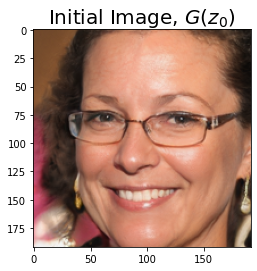

In [14]:
# initialize random latent
z = torch.randn(1, latent_dim, device=device)
with torch.no_grad():
    x = G([z])[0]
    x = stylegan_postprocess(x)
    x_init = process(x)
    plt.imshow(x_init)
    plt.title(r"Initial Image, $G(z_0)$", fontsize=20)

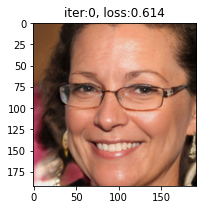

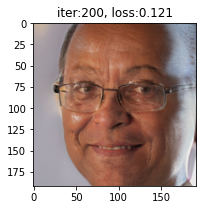

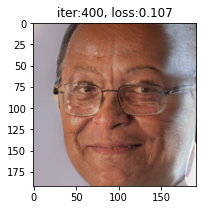

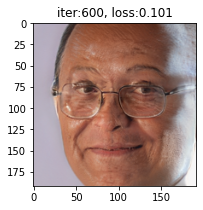

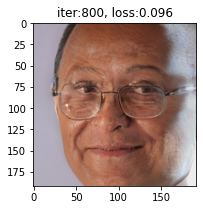

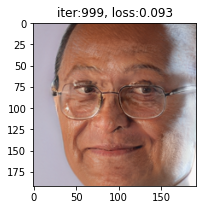

In [15]:
# wrap in nn.Parameter() to allow optimization
latent = nn.Parameter(z.clone())

# initialize optimizer & loss function
optimizer = optim.Adam([latent], lr=lr)  # Adam Optimizer
criterion = nn.MSELoss()                 # MSE Loss (L2 distance)

# for collecting image & latent sequence
image_sequence = []
latent_sequence = []

# Perform optimization
for i in range(iters):
    x = G([latent])[0]
    x = stylegan_postprocess(x)
    loss = criterion(x, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%viz_freq == 0 or i==iters-1:
        # save image sequence
        image_sequence.append(x)
        
        # save latent sequence: for interpolation
        latent_sequence.append(latent.detach().cpu())
        
        # visualize
        plt.figure(figsize=(3,3))
        plt.imshow(process(x))
        plt.title('iter:{}, loss:{:.3f}'.format(i, loss.item()))
        plt.show()

## Visualize Image Sequence

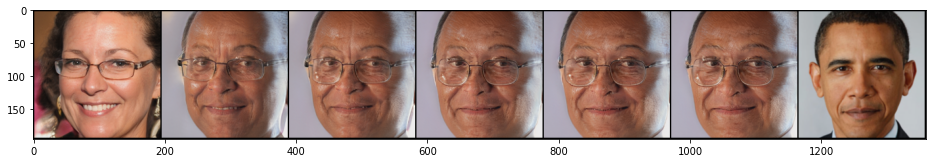

In [16]:
# visualize & save image sequence
imseq = process_image_sequence(image_sequence, target)
plt.figure(figsize=(16,4))
plt.imshow(imseq)
# plt.savefig(f'results/{target_name}/image_sequence.jpg', bbox_inches='tight')

# save latent sequence
latentseq = torch.vstack(latent_sequence).numpy()
# np.save(f'results/{target_name}/latent_sequence',latentseq)

# Evaluation: L2, LPIPS, and Cosine Distance

In [19]:
output = image_sequence[-1]  # final output
dist_l2 = F.mse_loss(output, target)   # L2 distance
dist_lpips = l_lpips(output, target)   # LPIPS distance
dist_cosine = l_cosine(output, target) # Cosine distance
print("L2: {:.4f}\nLPIPS: {:.4f}\nCosine: {:.4f}".format(dist_l2.item(), 
                                                        dist_lpips.item(), dist_cosine.item()))

L2: 0.0934
LPIPS: 2.0424
Cosine: 0.8633


In [31]:
import glob 
dirs = glob.glob('/content/drive/MyDrive/STDL_2022_Fall_GAN_Inversion/STDL_2022_Fall_GAN_Inversion/targets/*')
targets = []

import warnings
warnings.filterwarnings('ignore')


L2_list = []
LPIPS_list = []
Cosine_list = []

for dir in dirs:
  targets.append(dir.split("/")[-1])
lr = 0.01       # learning rate
iters = 1000     # number of iteration
viz_freq = 200  # visualize every 100 iterations


for target_name in targets:
  imdir = f'{base_directory}/targets/{target_name}'  
  target = Image.open(imdir).resize((image_size,image_size))
  target = transform(target)
  target = target.unsqueeze(0).to(device)

  z = torch.randn(1, latent_dim, device=device)
  latent = nn.Parameter(z.clone())

  optimizer = optim.Adam([latent], lr=lr)  # Adam Optimizer
  criterion = nn.MSELoss() 

  image_sequence = []
  latent_sequence = []
  print("target : ", target_name)
  # Perform optimization
  for i in range(iters):
      x = G([latent])[0]
      x = stylegan_postprocess(x)
      loss = criterion(x, target)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if i%viz_freq == 0 or i==iters-1:
          # save image sequence
          image_sequence.append(x)
          
          # save latent sequence: for interpolation
          latent_sequence.append(latent.detach().cpu())
        
          
  output = image_sequence[-1]  # final output
  dist_l2 = F.mse_loss(output, target)   # L2 distance
  dist_lpips = l_lpips(output, target)   # LPIPS distance
  dist_cosine = l_cosine(output, target) # Cosine distance
  print("L2: {:.4f}\nLPIPS: {:.4f}\nCosine: {:.4f}".format(dist_l2.item(), 
                                                          dist_lpips.item(), dist_cosine.item()))
 

  L2_list.append(F.mse_loss(output, target))
  LPIPS_list.append(l_lpips(output, target))   # LPIPS distance
  Cosine_list.append(l_cosine(output, target)) # Cosine distance

print(L2_list)
print(LPIPS_list)
print(Cosine_list)


target :  jennie.jpg
L2: 0.0725
LPIPS: 1.7212
Cosine: 1.0672
target :  jennie2.jpg
L2: 0.0656
LPIPS: 1.7262
Cosine: 0.7801
target :  kyrie.jpg
L2: 0.0660
LPIPS: 1.5519
Cosine: 0.9069
target :  potter.jpg
L2: 0.1212
LPIPS: 2.0350
Cosine: 0.9727
target :  tom.png
L2: 0.0716
LPIPS: 1.9431
Cosine: 0.7176
target :  tom2.png
L2: 0.0584
LPIPS: 1.7436
Cosine: 1.1692
target :  katie.jpg
L2: 0.0903
LPIPS: 1.8962
Cosine: 1.2524
target :  freeman.png
L2: 0.1143
LPIPS: 2.1840
Cosine: 0.7081
target :  jennifer.png
L2: 0.0677
LPIPS: 1.6523
Cosine: 0.7895
target :  yuna.jpg
L2: 0.1127
LPIPS: 2.1231
Cosine: 1.0864
target :  faker.jpg
L2: 0.0518
LPIPS: 1.8377
Cosine: 0.9552
target :  obama.jpg
L2: 0.0490
LPIPS: 1.5865
Cosine: 0.7067
target :  trump.jpg
L2: 0.0670
LPIPS: 1.9160
Cosine: 1.1172
target :  elon.jpg
L2: 0.1627
LPIPS: 2.0773
Cosine: 0.8757
target :  kyrie2.jpg
L2: 0.0748
LPIPS: 2.0748
Cosine: 0.7909
target :  emma.jpg
L2: 0.1080
LPIPS: 2.3076
Cosine: 0.8347
target :  tilda.jpg
L2: 0.0936
LPIPS

In [33]:
#L2_list
print(torch.mean(torch.tensor(L2_list)))
print(torch.std(torch.tensor(L2_list)))
#LPIPS_list
print(torch.mean(torch.tensor(LPIPS_list)))
print(torch.std(torch.tensor(LPIPS_list)))
#Cosine_list
print(torch.mean(torch.tensor(Cosine_list)))
print(torch.std(torch.tensor(Cosine_list)))



tensor(0.0859)
tensor(0.0305)
tensor(1.9371)
tensor(0.2453)
tensor(0.9122)
tensor(0.1600)


In [ ]:
L2 = [0.0430, 0.0601, 0.0968, 0.0793, 0.0408, 0.0772, 0.0806, 0.1356, 0.0779, 0.0439, 0.0685, 0.1050, 0.0414, 0.0763, 0.0637]
LPIPS = [1.5477,2.0069, 1.9701, 1.8554, 1.7142, 2.0.0., 2.0665, 2.3078, 1.8457, 1.6996, 1.7909, 2.2111, 1.5429, 1.6944, 1.5551]
Cosine = [0.6331, 1.0205, 0.9540, 0.8767, 0.3848, 1.0676,1.0160, 1.1586, 1.2189, 0.7652, 1.0429, 0.7801, 0.5508, 0.8222, 0.5357]

print(len(L2))
print(len(LPIPS))
print(len(Cosine))

target :  jennie.jpg


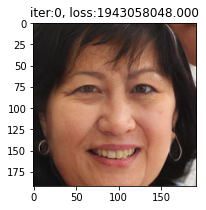

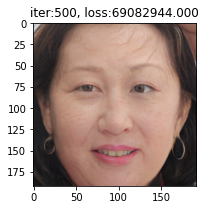

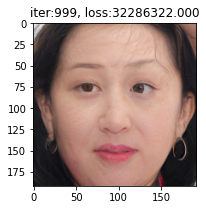

0/20
L2: 0.0514
LPIPS: 1.6440
Cosine: 0.6697
target :  jennie2.jpg


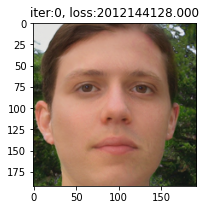

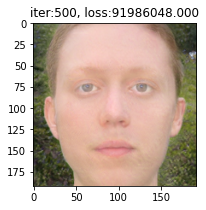

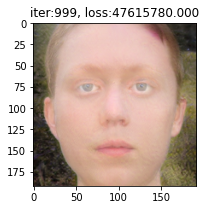

1/20
L2: 0.0624
LPIPS: 1.7066
Cosine: 0.9741
target :  kyrie.jpg


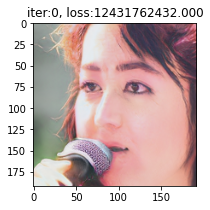

KeyboardInterrupt: ignored

In [44]:
L2_list = []
LIPIPS_list = []
Cosine_list = []
import glob 
dirs = glob.glob('/content/drive/MyDrive/STDL_2022_Fall_GAN_Inversion/STDL_2022_Fall_GAN_Inversion/targets/*')
targets = []

import warnings
warnings.filterwarnings('ignore')

for dir in dirs:
  targets.append(dir.split("/")[-1])

lr = 0.001       # learning rate
iters = 1000     # number of iteration
viz_freq = 500  # visualize every 100 iterations


for ind, target_name in enumerate(targets[:10]):
  imdir = f'{base_directory}/targets/{target_name}'  
  target = Image.open(imdir).resize((image_size,image_size))
  target = transform(target)
  target = target.unsqueeze(0).to(device)

  z = torch.randn(1, latent_dim, device=device)
  with torch.no_grad():
      w = G.style(z)  # w = f(z)
      wp = w.unsqueeze(1).repeat(1,14,1)
  latent = nn.Parameter(wp)

  optimizer = optim.Adam([latent], lr=lr)  # Adam Optimizer
  criterion = nn.MSELoss(reduction="sum") 

  image_sequence = []
  latent_sequence = []
  print("target : ", target_name)
  # Perform optimization
  for i in range(iters):
      
      x = G([latent], input_is_latent=True)[0]      
      x = stylegan_postprocess(x)
      loss_mse = criterion(x, target)
      loss = loss_mse **2
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if i%viz_freq == 0 or i==iters-1:
          # save image sequence
          image_sequence.append(x)
          
          # save latent sequence: for interpolation
          latent_sequence.append(latent.detach().cpu())
          
          # visualize
          plt.figure(figsize=(3,3))
          plt.imshow(process(x))
          plt.title('iter:{}, loss:{:.3f}'.format(i, loss.item()))
          plt.show()
          
  output = image_sequence[-1]  # final output
  L2_distance = F.mse_loss(output, target)   # L2 distance
  LPIPS_distance = l_lpips(output, target)   # LPIPS distance
  Cosine_distance = l_cosine(output, target) # Cosine distance

  L2_list.append(L2_distance)
  LPIPS_list.append(LPIPS_distance)
  Cosine_list.append(Cosine_distance)
  print("{}/{}".format(ind, len(targets)))
  print("L2: {:.4f}\nLPIPS: {:.4f}\nCosine: {:.4f}".format(L2_distance.item(), 
                                                          LPIPS_distance.item(), Cosine_distance.item()))
  
print("w+ space and 가중치는 학습되지 않음")
print("l2 mean : ", torch.mean(torch.tensor(L2_list)))
print("l2 std : ", torch.std(torch.tensor(L2_list)))
#lpips_list
print("lpips mean : ", torch.mean(torch.tensor(LPIPS_list)))
print("lpips std : ", torch.std(torch.tensor(LPIPS_list)))
#cosine_list
print("cosine mean : ", torch.mean(torch.tensor(Cosine_list)))
print("cosine std : ", torch.std(torch.tensor(Cosine_list)))

target :  jennie.jpg


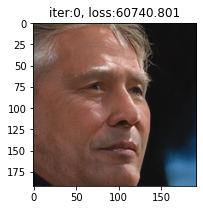

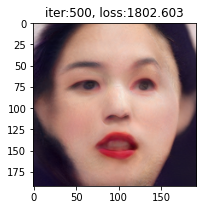

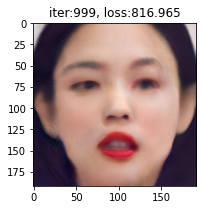

0/20
L2: 0.0074
LPIPS: 1.1103
Cosine: 0.2036
target :  jennie2.jpg


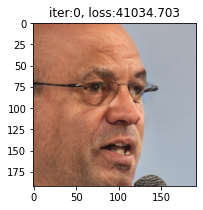

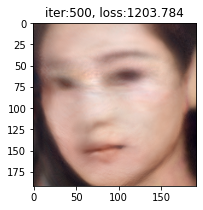

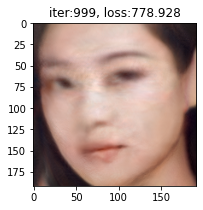

1/20
L2: 0.0070
LPIPS: 1.1336
Cosine: 0.4512
target :  kyrie.jpg


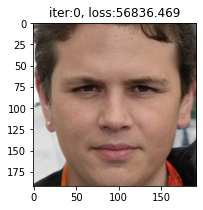

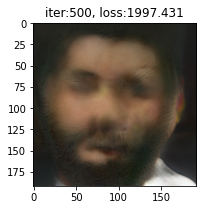

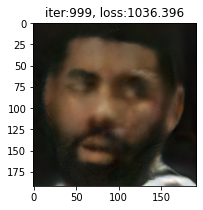

2/20
L2: 0.0094
LPIPS: 1.2118
Cosine: 0.2264
target :  potter.jpg


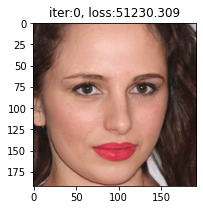

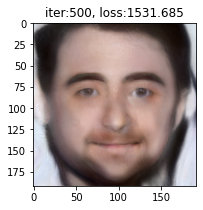

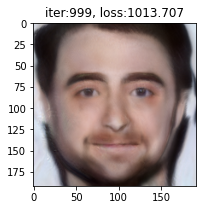

3/20
L2: 0.0092
LPIPS: 1.3368
Cosine: 0.2818
target :  tom.png


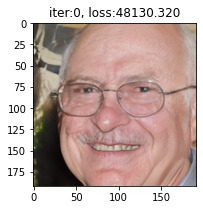

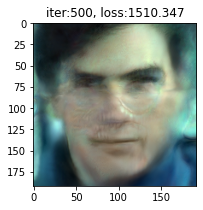

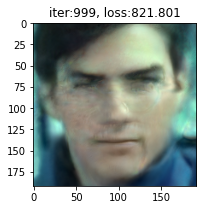

4/20
L2: 0.0074
LPIPS: 1.2233
Cosine: 0.3246
target :  tom2.png


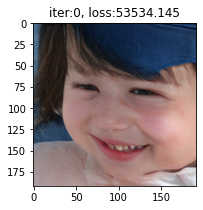

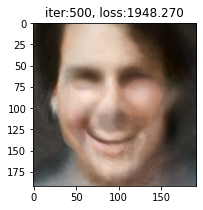

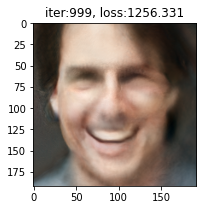

5/20
L2: 0.0114
LPIPS: 1.3421
Cosine: 0.2007
target :  katie.jpg


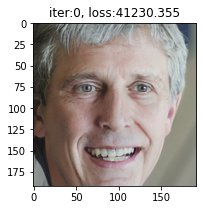

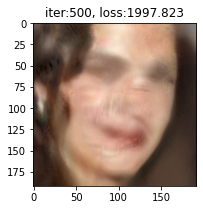

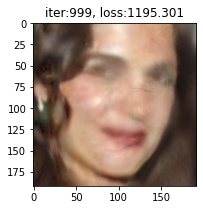

6/20
L2: 0.0108
LPIPS: 1.3121
Cosine: 0.3105
target :  freeman.png


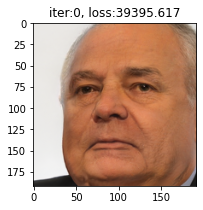

KeyboardInterrupt: ignored

In [48]:
L2_list = []
LPIPS_list = []
Cosine_list = []

import glob 
dirs = glob.glob('/content/drive/MyDrive/STDL_2022_Fall_GAN_Inversion/STDL_2022_Fall_GAN_Inversion/targets/*')
targets = []

import warnings
warnings.filterwarnings('ignore')

for dir in dirs:
  targets.append(dir.split("/")[-1])

lr = 0.01       # learning rate
iters = 1000     # number of iteration
viz_freq = 500  # visualize every 100 iterations


alpha = torch.randn(1, device=device)
alpha = nn.Parameter(alpha.clone())
beta = torch.randn(1, device=device)
beta = nn.Parameter(beta.clone())
gamma = torch.randn(1, device=device)
gamma = nn.Parameter(gamma.clone())

for ind, target_name in enumerate(targets[:10]):
  imdir = f'{base_directory}/targets/{target_name}'  
  target = Image.open(imdir).resize((image_size,image_size))
  target = transform(target)
  target = target.unsqueeze(0).to(device)

  z = torch.randn(1, latent_dim, device=device)
  with torch.no_grad():
      w = G.style(z)  # w = f(z)
      wp = w.unsqueeze(1).repeat(1,14,1)
  latent = nn.Parameter(wp)

  optimizer = optim.Adam([latent], lr=lr)  # Adam Optimizer
  criterion = nn.MSELoss(reduction="sum") 

  image_sequence = []
  latent_sequence = []
  print("target : ", target_name)
  # Perform optimization
  for i in range(iters):
      #x = G([latent])[0]
      x = G([latent], input_is_latent=True)[0]      
      x = stylegan_postprocess(x)
      loss_mse = criterion(x, target)
      loss_LPIPS = l_lpips(x, target) * beta 
      loss_Cosine = l_cosine(x, target) * gamma 
      loss = loss_mse + loss_LPIPS + loss_Cosine
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if i%viz_freq == 0 or i==iters-1:
          # save image sequence
          image_sequence.append(x)
          
          # save latent sequence: for interpolation
          latent_sequence.append(latent.detach().cpu())
          
          # visualize
          plt.figure(figsize=(3,3))
          plt.imshow(process(x))
          plt.title('iter:{}, loss:{:.3f}'.format(i, loss.item()))
          plt.show()
          
  output = image_sequence[-1]  # final output
  L2_distance = F.mse_loss(output, target)   # L2 distance
  LPIPS_distance = l_lpips(output, target)   # LPIPS distance
  Cosine_distance = l_cosine(output, target) # Cosine distance
  L2_list.append(L2_distance)
  LPIPS_list.append(LPIPS_distance)
  Cosine_list.append(Cosine_distance)
  print("{}/{}".format(ind, len(targets)))
  print("L2: {:.4f}\nLPIPS: {:.4f}\nCosine: {:.4f}".format(L2_distance.item(), 
                                                          LPIPS_distance.item(), Cosine_distance.item()))
  
print("w+ space and 가중치는 학습되지 않음")
print("L2 mean : ", torch.mean(torch.tensor(L2_list)))
print("L2 std : ", torch.std(torch.tensor(L2_list)))
#lpips_list
print("LPIPS mean : ", torch.mean(torch.tensor(LPIPS_list)))
print("LPIPS std : ", torch.std(torch.tensor(LPIPS_list)))
#cosine_list
print("Cosine mean : ", torch.mean(torch.tensor(Cosine_list)))
print("Cosine std : ", torch.std(torch.tensor(Cosine_list)))

In [43]:
alpha, beta, gamma

(Parameter containing:
 tensor([1.6197], device='cuda:0', requires_grad=True), Parameter containing:
 tensor([1.1073], device='cuda:0', requires_grad=True), Parameter containing:
 tensor([0.7101], device='cuda:0', requires_grad=True))

target :  jennie.jpg
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


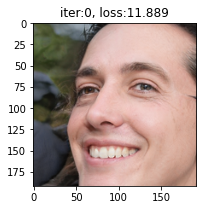

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


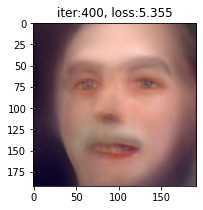

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


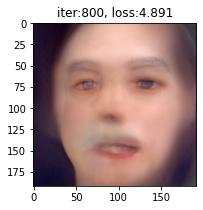

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


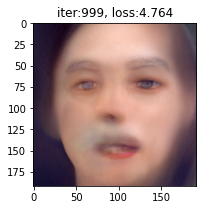

0/20
L2: 0.0683
LPIPS: 1.1436
Cosine: 0.0132
target :  jennie2.jpg
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


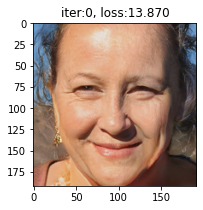

KeyboardInterrupt: ignored

In [49]:
# w space and 가중치는 학습되지 않음
l2_list = []
lpips_list = []
cosine_list = []
import glob 
dirs = glob.glob('/content/drive/MyDrive/STDL_2022_Fall_GAN_Inversion/STDL_2022_Fall_GAN_Inversion/targets/*')
targets = []

import warnings
warnings.filterwarnings('ignore')

for dir in dirs:
  targets.append(dir.split("/")[-1])

lr = 0.01       # learning rate
iters = 1000     # number of iteration
viz_freq = 400  # visualize every 100 iterations


#alpha = torch.randn(1, device=device)
#alpha = nn.Parameter(alpha.clone())
#beta = torch.randn(1, device=device)
#beta = torch.tensor([1.1], requires_grad=True).cuda()
#beta = nn.Parameter(beta.clone())
#beta = nn.Parameter(torch.tensor([1.])).cuda()
#gamma = torch.randn(1, device=device)
#gamma = torch.tensor([0.7], requires_grad=True).cuda()
#gamma = nn.Parameter(torch.tensor(1., device=device))
#gamma = nn.Parameter(gamma.clone())

for ind, target_name in enumerate(targets[:10]):
  imdir = f'{base_directory}/targets/{target_name}'  
  target = Image.open(imdir).resize((image_size,image_size))
  target = transform(target)
  target = target.unsqueeze(0).to(device)

  z = torch.randn(1, latent_dim, device=device)
  with torch.no_grad():
      w = G.style(z)  # w = f(z)
      wp = w.unsqueeze(1).repeat(1,14,1)
  latent = nn.Parameter(wp)

  optimizer = optim.Adam([latent], lr=lr)  # Adam Optimizer
  criterion = nn.MSELoss(reduction="mean") 

  image_sequence = []
  latent_sequence = []
  print("target : ", target_name)
  # Perform optimization
  for i in range(iters):
      
      #x = G([latent])[0]
      x = G([latent], input_is_latent=True)[0]      
      x = stylegan_postprocess(x)
      loss_mse = criterion(x, target) * 2
      loss_lpips = l_lpips(x, target) * 4
      #loss_lpips = l_lpips(x, target) * 1.1
      loss_cosine = l_cosine(x, target) * 4 
      #loss_cosine = l_cosine(x, target) * 0.7
      loss = loss_mse + loss_lpips + loss_cosine
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if i%viz_freq == 0 or i==iters-1:
          # save image sequence
          image_sequence.append(x)
          
          # save latent sequence: for interpolation
          latent_sequence.append(latent.detach().cpu())
          print(alpha.item(), beta.item(), gamma.item())
          # visualize
          plt.figure(figsize=(3,3))
          plt.imshow(process(x))
          plt.title('iter:{}, loss:{:.3f}'.format(i, loss.item()))
          plt.show()
          
  output = image_sequence[-1]  # final output
  dist_l2 = F.mse_loss(output, target)   # L2 distance
  dist_lpips = l_lpips(output, target)   # LPIPS distance
  dist_cosine = l_cosine(output, target) # Cosine distance
  l2_list.append(dist_l2)
  lpips_list.append(dist_lpips)
  cosine_list.append(dist_cosine)
  print("{}/{}".format(ind, len(targets)))
  print("L2: {:.4f}\nLPIPS: {:.4f}\nCosine: {:.4f}".format(dist_l2.item(), 
                                                          dist_lpips.item(), dist_cosine.item()))
  
print("w+ space and 가중치는 학습되지 않음")
print("l2 mean : ", torch.mean(torch.tensor(l2_list)))
print("l2 std : ", torch.std(torch.tensor(l2_list)))
#lpips_list
print("lpips mean : ", torch.mean(torch.tensor(lpips_list)))
print("lpips mean : ", torch.std(torch.tensor(lpips_list)))
#cosine_list
print("cosine mean : ", torch.mean(torch.tensor(cosine_list)))
print("cosine mean : ", torch.std(torch.tensor(cosine_list)))

target :  jennie.jpg
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


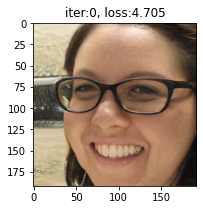

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


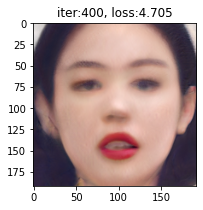

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


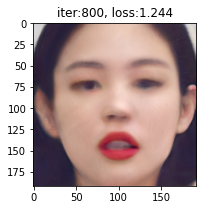

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


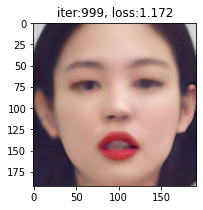

0/20
L2: 0.0044
LPIPS: 0.9615
Cosine: 0.2103
target :  jennie2.jpg
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


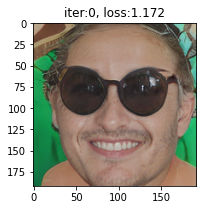

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


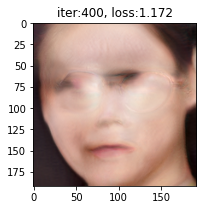

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


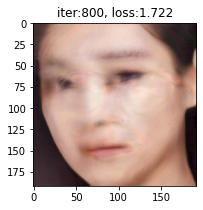

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


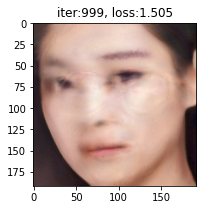

1/20
L2: 0.0062
LPIPS: 1.0797
Cosine: 0.4248
target :  kyrie.jpg
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


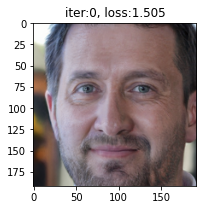

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


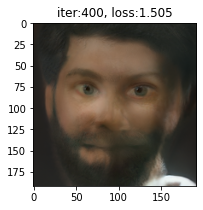

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


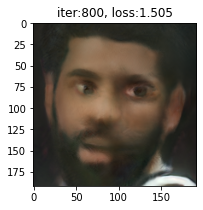

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


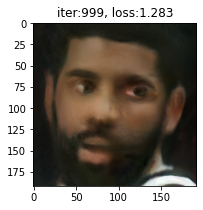

2/20
L2: 0.0068
LPIPS: 1.1215
Cosine: 0.1616
target :  potter.jpg
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


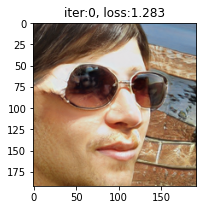

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


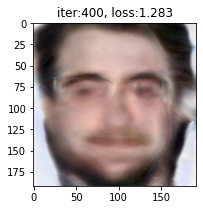

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


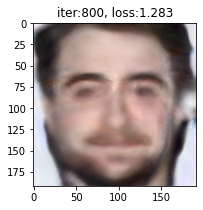

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


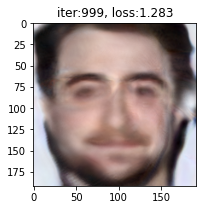

3/20
L2: 0.0133
LPIPS: 1.4695
Cosine: 0.3006
target :  tom.png
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


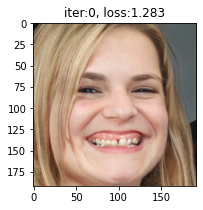

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


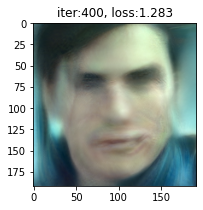

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


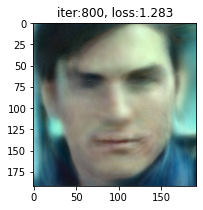

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


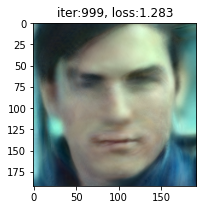

4/20
L2: 0.0084
LPIPS: 1.2064
Cosine: 0.3079
target :  tom2.png
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


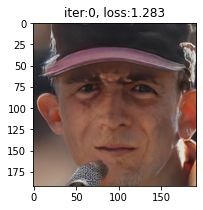

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


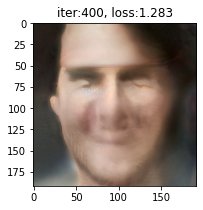

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


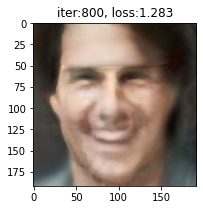

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


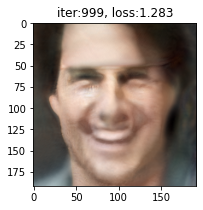

5/20
L2: 0.0110
LPIPS: 1.3603
Cosine: 0.2488
target :  katie.jpg
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


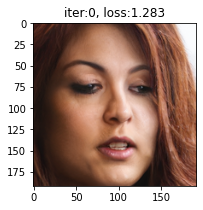

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


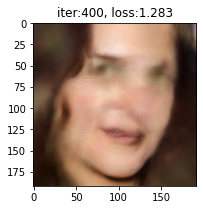

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


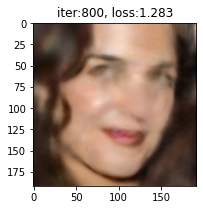

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


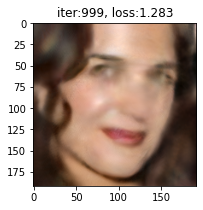

6/20
L2: 0.0100
LPIPS: 1.2131
Cosine: 0.2698
target :  freeman.png
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


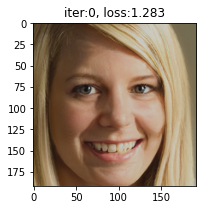

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


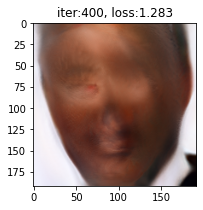

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


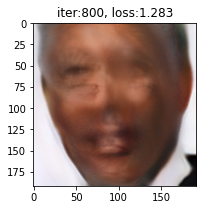

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


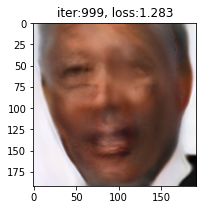

7/20
L2: 0.0122
LPIPS: 1.3561
Cosine: 0.3507
target :  jennifer.png
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


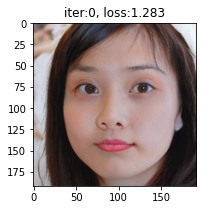

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


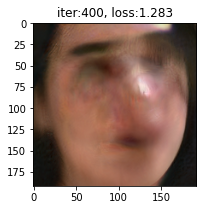

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


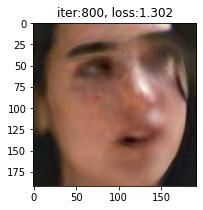

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


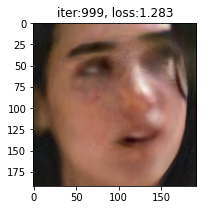

8/20
L2: 0.0059
LPIPS: 1.0561
Cosine: 0.2268
target :  yuna.jpg
-0.25820109248161316 0.02614363096654415 -1.1217365264892578


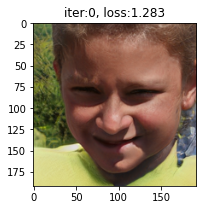

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


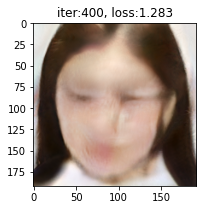

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


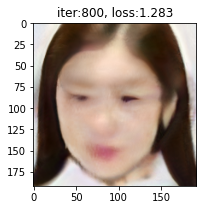

-0.25820109248161316 0.02614363096654415 -1.1217365264892578


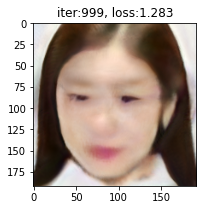

9/20
L2: 0.0107
LPIPS: 1.3151
Cosine: 0.2990
w+ space and 가중치는 학습되지 않음
l2 mean :  tensor(0.0089)
l2 std :  tensor(0.0030)
lpips mean :  tensor(1.2139)
lpips mean :  tensor(0.1607)
cosine mean :  tensor(0.2800)
cosine mean :  tensor(0.0748)


In [51]:
# w space and 가중치는 학습되지 않음
l2_list = []
lpips_list = []
cosine_list = []
import glob 
dirs = glob.glob('/content/drive/MyDrive/STDL_2022_Fall_GAN_Inversion/STDL_2022_Fall_GAN_Inversion/targets/*')
targets = []

import warnings
warnings.filterwarnings('ignore')

for dir in dirs:
  targets.append(dir.split("/")[-1])

lr = 0.01       # learning rate
iters = 1000     # number of iteration
viz_freq = 400  # visualize every 100 iterations


#alpha = torch.randn(1, device=device)
#alpha = nn.Parameter(alpha.clone())
#beta = torch.randn(1, device=device)
#beta = torch.tensor([1.1], requires_grad=True).cuda()
#beta = nn.Parameter(beta.clone())
#beta = nn.Parameter(torch.tensor([1.])).cuda()
#gamma = torch.randn(1, device=device)
#gamma = torch.tensor([0.7], requires_grad=True).cuda()
#gamma = nn.Parameter(torch.tensor(1., device=device))
#gamma = nn.Parameter(gamma.clone())

for ind, target_name in enumerate(targets[:10]):
  imdir = f'{base_directory}/targets/{target_name}'  
  target = Image.open(imdir).resize((image_size,image_size))
  target = transform(target)
  target = target.unsqueeze(0).to(device)

  z = torch.randn(1, latent_dim, device=device)
  with torch.no_grad():
      w = G.style(z)  # w = f(z)
      wp = w.unsqueeze(1).repeat(1,14,1)
  latent = nn.Parameter(wp)

  optimizer = optim.Adam([latent], lr=lr)  # Adam Optimizer
  criterion = nn.MSELoss(reduction="mean") 

  image_sequence = []
  latent_sequence = []
  print("target : ", target_name)
  # Perform optimization
  for i in range(iters):
      
      #x = G([latent])[0]
      x = G([latent], input_is_latent=True)[0]      
      x = stylegan_postprocess(x)
    
      loss_mse = criterion(x, target) * 2
      if loss_mse > 0.015:
        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()
      else:
        loss_lpips = l_lpips(x, target)
        loss_cosine = l_cosine(x, target)
        loss = loss_lpips + loss_cosine
        optimizer.zero_grad()
        loss_mse.backward()
        optimizer.step()        
      #loss_lpips = l_lpips(x, target) * 4
      #loss_lpips = l_lpips(x, target) * 1.1
      #loss_cosine = l_cosine(x, target) * 4 
      #loss_cosine = l_cosine(x, target) * 0.7
      #loss = loss_mse + loss_lpips + loss_cosine
      
      #optimizer.zero_grad()
      #loss.backward()
      #optimizer.step()
      
      if i%viz_freq == 0 or i==iters-1:
          # save image sequence
          image_sequence.append(x)
          
          # save latent sequence: for interpolation
          latent_sequence.append(latent.detach().cpu())
          print(alpha.item(), beta.item(), gamma.item())
          # visualize
          plt.figure(figsize=(3,3))
          plt.imshow(process(x))
          plt.title('iter:{}, loss:{:.3f}'.format(i, loss.item()))
          plt.show()
          
  output = image_sequence[-1]  # final output
  dist_l2 = F.mse_loss(output, target)   # L2 distance
  dist_lpips = l_lpips(output, target)   # LPIPS distance
  dist_cosine = l_cosine(output, target) # Cosine distance
  l2_list.append(dist_l2)
  lpips_list.append(dist_lpips)
  cosine_list.append(dist_cosine)
  print("{}/{}".format(ind, len(targets)))
  print("L2: {:.4f}\nLPIPS: {:.4f}\nCosine: {:.4f}".format(dist_l2.item(), 
                                                          dist_lpips.item(), dist_cosine.item()))
  
print("w+ space and 가중치는 학습되지 않음")
print("l2 mean : ", torch.mean(torch.tensor(l2_list)))
print("l2 std : ", torch.std(torch.tensor(l2_list)))
#lpips_list
print("lpips mean : ", torch.mean(torch.tensor(lpips_list)))
print("lpips mean : ", torch.std(torch.tensor(lpips_list)))
#cosine_list
print("cosine mean : ", torch.mean(torch.tensor(cosine_list)))
print("cosine mean : ", torch.std(torch.tensor(cosine_list)))

# 1.2. Optimization on the W space
Here, we repeat the above experiment on the $\mathcal{W}$ space.
- Initialize latent vector: here, we simply initialize randomly, i.e., $w_0 = f(z_0), \text{ where } z_0\sim \mathcal{N}(0,I)$.
- NOTE: **input_is_latent = True** when using the $w$ latent vector

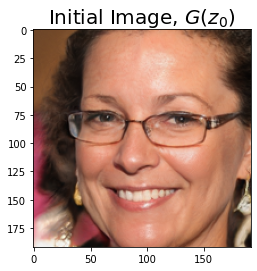

In [20]:
# NOTE: here we reuse the z0 initialized in the first experiment
with torch.no_grad():
    w = G.style(z)  # w = f(z)
    
with torch.no_grad():
    x = G([w], input_is_latent=True)[0]
    x = stylegan_postprocess(x)
    x_init = process(x)
    plt.imshow(x_init)
    plt.title(r"Initial Image, $G(z_0)$", fontsize=20)

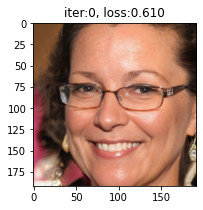

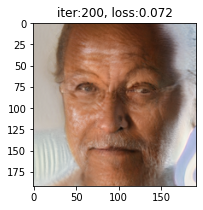

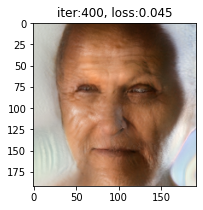

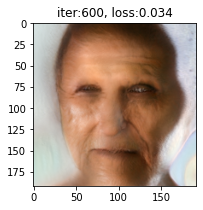

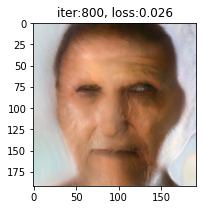

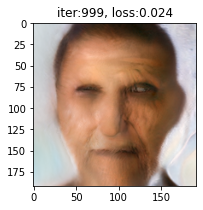

In [21]:
# project z to W space through mapping function f
with torch.no_grad():
    w = G.style(z)  # w = f(z)

# wrap in nn.Parameter() to allow optimization
latent = nn.Parameter(w)

# initialize optimizer & loss function
optimizer = optim.Adam([latent], lr=lr)  # Adam Optimizer
criterion = nn.MSELoss()                 # MSE Loss (L2 distance)

# for collecting image & latent sequence
image_sequence = []
latent_sequence = []

# Perform optimization
for i in range(iters):
    x = G([latent], input_is_latent=True)[0]  # NOTE: input_is_latent=True for w space
    x = stylegan_postprocess(x)
    loss = criterion(x, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%viz_freq == 0 or i==iters-1:
        # save image sequence
        image_sequence.append(x)
        
        # save latent sequence: for interpolation
        latent_sequence.append(latent.detach().cpu())
        
        # visualize
        plt.figure(figsize=(3,3))
        plt.imshow(process(x))
        plt.title('iter:{}, loss:{:.3f}'.format(i, loss.item()))
        plt.show()

## Visualize Image Sequence

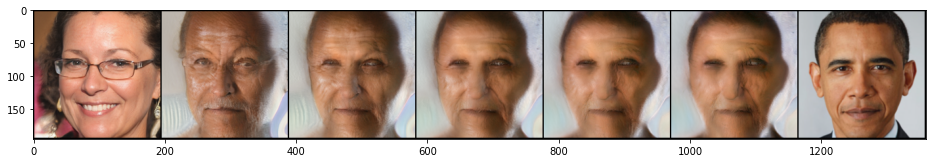

In [22]:
# visualize & save image sequence
imseq = process_image_sequence(image_sequence, target)
plt.figure(figsize=(16,4))
plt.imshow(imseq)
# plt.savefig(f'results/{target_name}/image_sequence.jpg', bbox_inches='tight')

# save latent sequence
latentseq = torch.vstack(latent_sequence).numpy()
# np.save(f'results/{target_name}/latent_sequence',latentseq)

# Evaluation: L2, LPIPS, and Cosine Distance

In [23]:
output = image_sequence[-1]  # final output
dist_l2 = F.mse_loss(output, target)   # L2 distance
dist_lpips = l_lpips(output, target)   # LPIPS distance
dist_cosine = l_cosine(output, target) # Cosine distance
print("L2: {:.4f}\nLPIPS: {:.4f}\nCosine: {:.4f}".format(dist_l2.item(), 
                                                        dist_lpips.item(), dist_cosine.item()))

L2: 0.0237
LPIPS: 1.5799
Cosine: 0.8564


# 1.3. Optimization on the W+ space
Here, we repeat the above experiment on the $\mathcal{W}^+$ space.
- Initialize latent vector: here, we simply initialize randomly, i.e., $w_0 = f(z_0), \text{ where } z_0\sim \mathcal{N}(0,I)$.
- Then, we repeat $w_0$ 14 times to create $w^+_0 = [w_0, ..., w_0]^T$
- NOTE: **input_is_latent = True** when using the $w^+$ latent vector

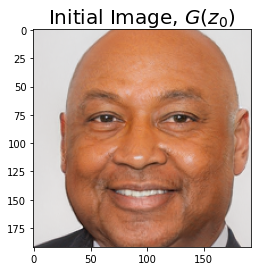

In [ ]:
# NOTE: here we reuse the z0 initialized in the first experiment
with torch.no_grad():
    w = G.style(z)  # w = f(z)
    wp = w.unsqueeze(1).repeat(1,14,1)  # shape: [1,14,512]
    
with torch.no_grad():
    x = G([wp], input_is_latent=True)[0]
    x = stylegan_postprocess(x)
    x_init = process(x)
    plt.imshow(x_init)
    plt.title(r"Initial Image, $G(z_0)$", fontsize=20)

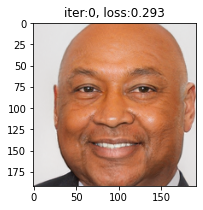

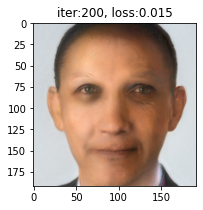

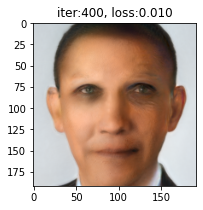

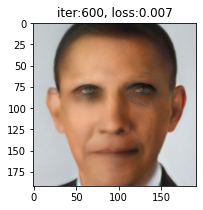

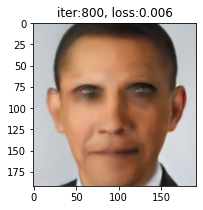

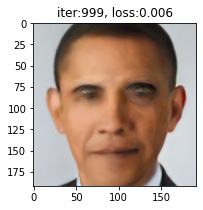

In [ ]:
# project z to W space through mapping function f
with torch.no_grad():
    w = G.style(z)  # w = f(z)
    wp = w.unsqueeze(1).repeat(1,14,1)  # shape: [1,14,512]

# wrap in nn.Parameter() to allow optimization
latent = nn.Parameter(wp)

# initialize optimizer & loss function
optimizer = optim.Adam([latent], lr=lr)  # Adam Optimizer
criterion = nn.MSELoss()                 # MSE Loss (L2 distance)

# for collecting image & latent sequence
image_sequence = []
latent_sequence = []

# Perform optimization
for i in range(iters):
    x = G([latent], input_is_latent=True)[0]  # NOTE: input_is_latent=True for w space
    x = stylegan_postprocess(x)
    loss = criterion(x, target)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%viz_freq == 0 or i==iters-1:
        # save image sequence
        image_sequence.append(x)
        
        # save latent sequence: for interpolation
        latent_sequence.append(latent.detach().cpu())
        
        # visualize
        plt.figure(figsize=(3,3))
        plt.imshow(process(x))
        plt.title('iter:{}, loss:{:.3f}'.format(i, loss.item()))
        plt.show()

## Visualize Image Sequence

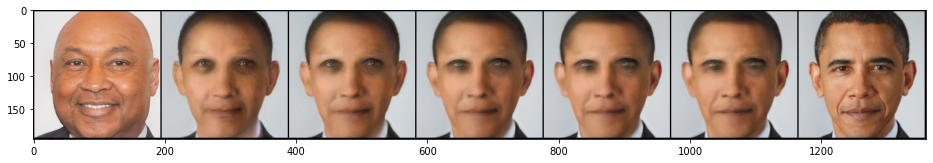

In [ ]:
# visualize & save image sequence
imseq = process_image_sequence(image_sequence, target)
plt.figure(figsize=(16,4))
plt.imshow(imseq)
# plt.savefig(f'results/{target_name}/image_sequence.jpg', bbox_inches='tight')

# save latent sequence
latentseq = torch.vstack(latent_sequence).numpy()
# np.save(f'results/{target_name}/latent_sequence',latentseq)

# Evaluation: L2, LPIPS, and Cosine Distance

In [ ]:
output = image_sequence[-1]  # final output
dist_l2 = F.mse_loss(output, target)   # L2 distance
dist_lpips = l_lpips(output, target)   # LPIPS distance
dist_cosine = l_cosine(output, target) # Cosine distance
print("L2: {:.4f}\nLPIPS: {:.4f}\nCosine: {:.4f}".format(dist_l2.item(), 
                                                        dist_lpips.item(), dist_cosine.item()))

L2: 0.0059
LPIPS: 1.0207
Cosine: 0.1115
